# Init

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 5.0MB/s 


# Prepare MNIST dataset

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Load Model

In [0]:
# define baseline model
class Perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [0]:
# build the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model = Perceptron(784, 784, 10).to(device)

from torchbearer.callbacks import StepLR
from torchbearer.callbacks.decorators import on_end_epoch

# def reduce_rate(state):
#   print(optimiser.lear)
sch = StepLR(step_size=75, gamma=0.1)

Train and test

In [7]:
%%time
# build the model
model = Perceptron(784, 784, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial = Trial(model, optimiser, loss_function,callbacks=[sch], metrics=['loss', 'accuracy','lr']).to(device)
trial.with_generators(trainloader, val_generator=testloader)
history = trial.run(epochs=100)

results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git


{}
CPU times: user 11min 34s, sys: 24 s, total: 11min 58s
Wall time: 13min 27s


In [0]:
def get_data(history,name):
  train_acc = [x['acc'] for x in history]
  train_loss = [x['loss'] for x in history]
  test_acc = [x['val_acc'] for x in history]
  test_loss = [x['val_loss'] for x in history]
  frame = pd.DataFrame(zip(train_acc,train_loss,test_acc,test_loss))
  frame.columns = ['train_acc','train_loss','val_acc','val_loss']
  frame.to_csv(name)
  return frame

In [0]:
frame = get_data(history,'MLP(SGD).csv')

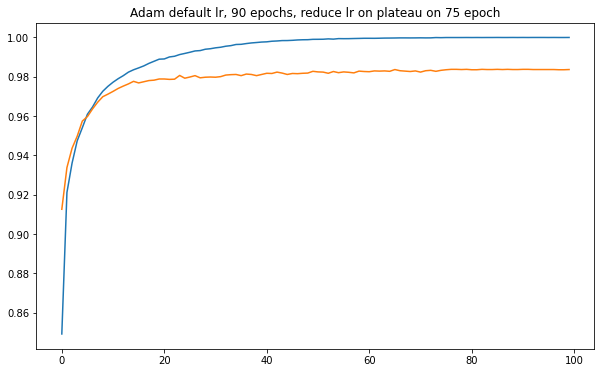

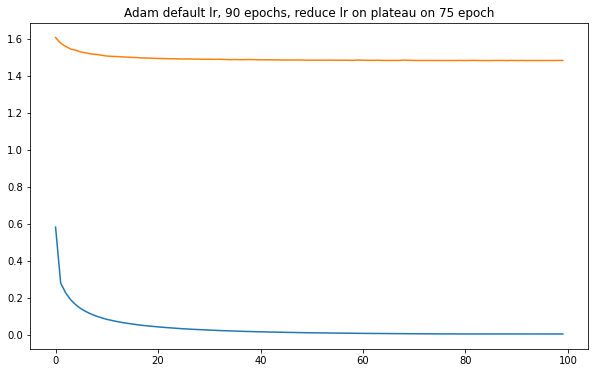

In [10]:
plt.figure(figsize=(10,6))
plt.title('Adam default lr, 90 epochs, reduce lr on plateau on 75 epoch')
plt.plot(range(100),frame['train_acc'])
plt.plot(range(100),frame['val_acc'])

plt.figure(figsize=(10,6))
plt.title('Adam default lr, 90 epochs, reduce lr on plateau on 75 epoch')
plt.plot(range(100),frame['train_loss'])
plt.plot(range(100),frame['val_loss'])

